# Predicting Prices using sML Regression models
Before, we predicted 'expensive' vs 'not expensive'. Now, we predict actual prices. 

Remember: *Every model is wrong, but some are useful.*

In [1]:
# import libraries
import pandas as pd
import numpy as np
from numpy import log1p
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, pearsonr, linregress 
#import plotly
import os
#import pycaret
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay, f1_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFECV, SelectFromModel


## Prepare data

Preprocessing is similiar to the categorization approach - see the other notebook

In [2]:
housing_num = pd.read_csv("data/housing_iteration_6_regression/housing_iteration_6_regression.csv")

In [3]:
# Define y and X
y = housing_num["SalePrice"]
X = housing_num.drop(["SalePrice", "Id"], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

In [4]:
# Define ordinal categories
ExterQual_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]  # use the N_A string we later introduce as a custom string to replace missing values
BsmtCond_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_cat = ["N_A", "No", "Mn", "Av", "Gd"]
BsmtFinType1_cat = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
KitchenQual_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
FireplaceQu_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
LotShape_cat = ["N_A","Reg", "IR1", "IR2", "IR3"]
Utilities_cat = ["N_A","ELO", "NoSeWa", "NoSewr", "AllPub"]
LandSlope_cat = ["N_A","Sev", "Mod", "Gtl"]
BsmtFinType2_cat = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
HeatingQC_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
Functional_cat = ["N_A","Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"]
GarageFinish_cat = ["N_A", "Unf", "RFn", "Fin"]
GarageQual_cat = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageCond_cat = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
PoolQC_cat = ["N_A", "Fa", "TA", "Gd", "Ex"]
Fence_cat = ["N_A", "MnWw", "GdWo", "MnPrv", "GdPrv"]


# select categorical and numerical column names
X_cat_columns = ["MSZoning", "Condition1", "Heating", "Street", "CentralAir", "Foundation", "MasVnrType", 
                 "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition2", "BldgType",
                 "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
                 "Electrical", "GarageType", "PavedDrive", "MiscFeature", "SaleType", "SaleCondition"]
X_ord_columns = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
                 "KitchenQual", "FireplaceQu", "LotShape", "Utilities", "LandSlope", "BsmtFinType2", 
                 "HeatingQC", "Functional", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                 "Fence"]
X_num_columns = X.select_dtypes(include="number").columns

## Dummy Model
create a very simple model to compare the better model against

in the last model, OverallQual was the most influential (10%) feature. Its histogram shows a good and comparable spread to SalePrice.


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

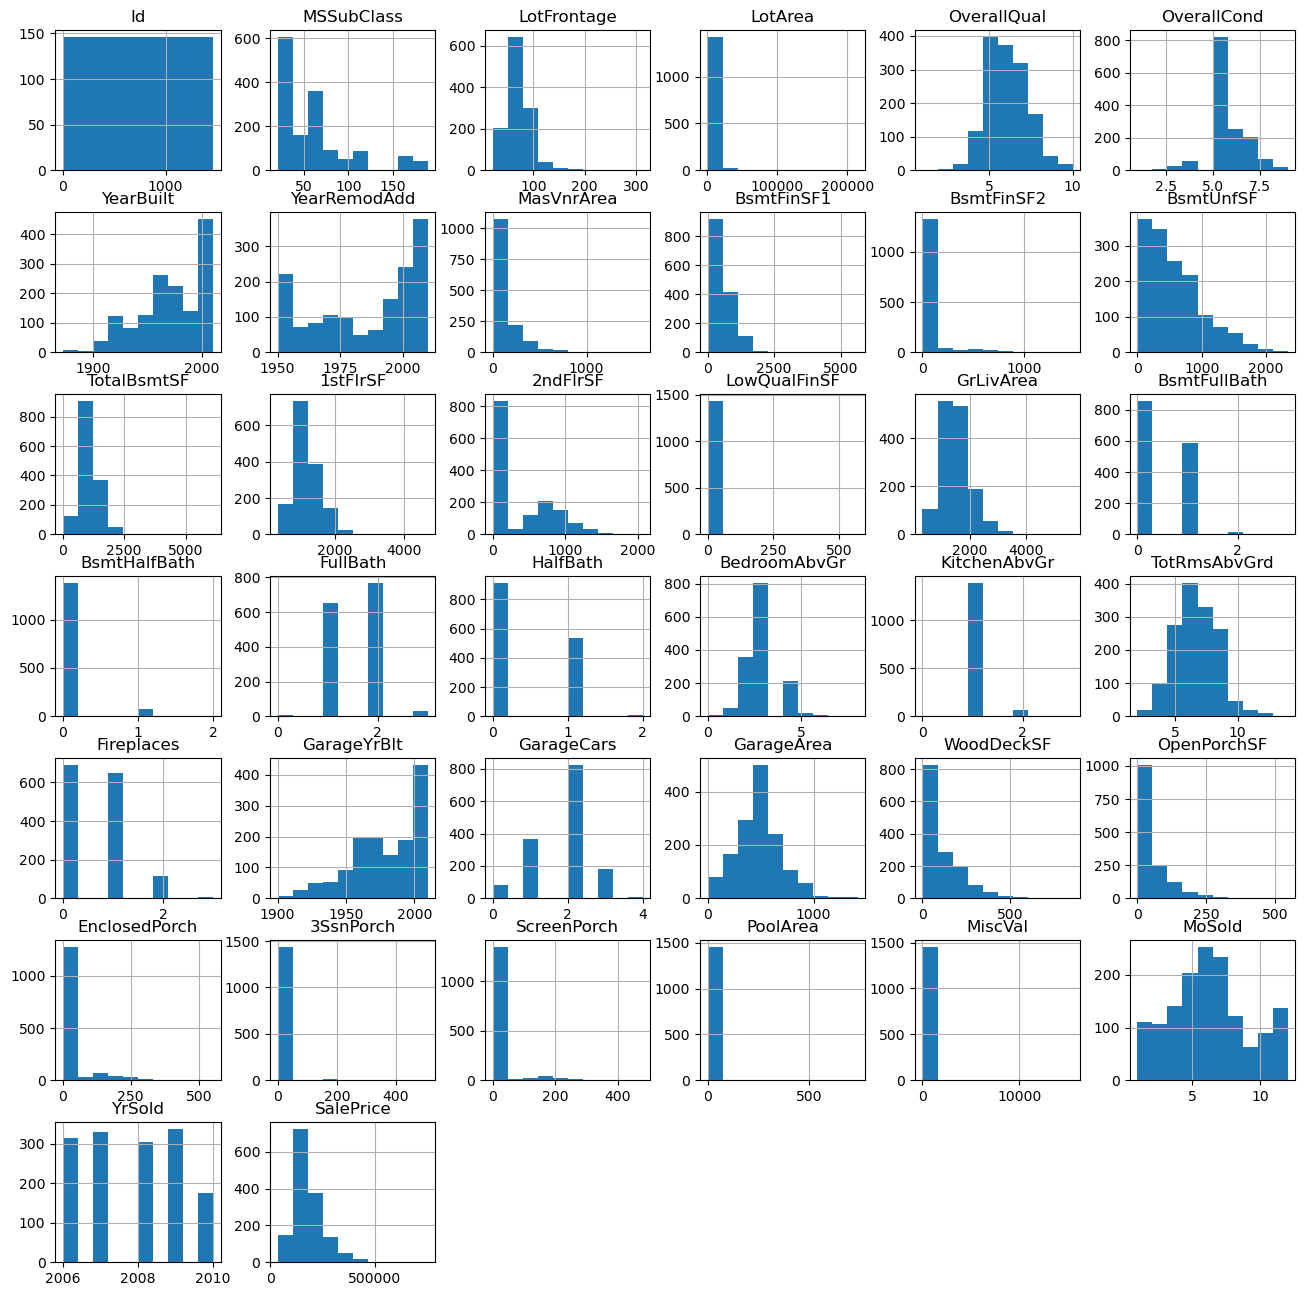

In [5]:
housing_num.hist(figsize=(16,16))

In [6]:
# Show Correlation of SalesPrice and OverallQual
sns.regplot(data=housing_num, y="SalePrice", x="OverallQual")

# Correlation Coeficient
corr, _ = pearsonr(x = housing_num.OverallQual, y=housing_num.SalePrice)
print('Pearsons correlation: %.3f' % corr)

# Linear Regression line parameters
slope, intercept, r_value, p_value, std_err = linregress(y=housing_num.SalePrice, x=housing_num.OverallQual)   
print("Regression Equation: y = {:.2f}x + {:.2f}".format(slope, intercept))


Pearsons correlation: 0.791
Regression Equation: y = 45435.80x + -96206.08


In [7]:
# Build Function for simple prediction
def linreg(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    predicted_y = slope * np.array(x) + intercept
    return predicted_y


In [50]:
# A functions that returns several regression model performance metrics to compare different models/pipelines to each other
def regression_perf(y_true, y_pred, model_name, save=False):
    # Create csv file, if it doesnt exist, else read it
    filename = 'data/model_performance_regression.csv'
    if not os.path.exists(filename):
        with open(filename, 'w'): pass
        performance_metrics = pd.DataFrame(columns=["model", "MAE", "MSQ", "MAPE", "R2", "RMSE"])
    else:
        performance_metrics = pd.read_csv(filename)

    if save==False:
        model_name = f"new (not saved): {model_name}"
  
    # make predictions on test and trained data
    mae = mean_absolute_error(y_true = y_true, y_pred = y_pred).round(1)
    sqe = mean_squared_error(y_true = y_true, y_pred = y_pred).round(1)
    ape = mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred).round(3)
    r2s = r2_score(y_true = y_true, y_pred = y_pred).round(3)
    rmsle = root_mean_squared_error(y_true = y_true, y_pred = y_pred).round(1)

    # compile new data and add to df
    new_data = pd.DataFrame({"model": model_name, "MAE": mae, "MSQ": sqe, "MAPE": ape, "R2": r2s, "RMSE": rmsle}, index=[0])
    performance_metrics = pd.concat([performance_metrics, new_data], ignore_index=True)

    # save to csv
    if save==True:
        performance_metrics.to_csv(filename, index = False)

    return performance_metrics

In [9]:
# predic price based on dummy model
dummy_y_pred_train = linreg(X_train.OverallQual, y_train)
dummy_y_pred_test = linreg(X_test.OverallQual, y_test)

# use dummy prediction to compute performance parameters
regression_perf(y_test, dummy_y_pred_test, "dummy", save=False)

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


model      MAE      MSQ   MAPE     R2     RMSE
0                            dummy  32465.8  47260.6  0.192  0.653      NaN
1                       DecTreeReg  26479.6  45431.9  0.153  0.679      NaN
2                           SDGReg  21669.2  36018.6  0.131  0.798      NaN
3                           LinReg  20752.8  36313.3  0.123  0.795      NaN
4                     RandomForest  15933.6  30369.0  0.091  0.857      NaN
5      RandomForest_col+log+no0var  15855.3  30125.6  0.093  0.859  30125.6
6  RandomForest_col+log+no0var+RFE  15732.8  30849.1  0.091  0.852  30849.1
7           new (not saved): dummy  32465.8  47260.6  0.192  0.653  47260.6

## Feature Selection and Engineering

there are several ways to test and select features that are e.g., non-influential (low or no variance) or colinear (highly correlated features) and can distort the model. 

I will play around with different approaches and print the model comparison in the csv in the next section.   

### Collinarity
Corrlation matrix and heatmap to find highly correlated features 

In [10]:
corr = housing_num.select_dtypes(np.number).drop(columns="SalePrice").corr()
corr_values = corr.unstack()
corr_values = corr_values.loc[corr_values!=1]
corr_values.sort_values(ascending=False).head(30)

GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
2ndFlrSF      GrLivArea       0.687501
GrLivArea     2ndFlrSF        0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
TotRmsAbvGrd  BedroomAbvGr    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
BsmtFullBath  BsmtFinSF1      0.649212
GarageYrBlt   YearRemodAdd    0.642277
YearRemodAdd  GarageYrBlt     0.642277
FullBath      GrLivArea       0.630012
GrLivArea     FullBath        0.630012
TotRmsAbvGrd  2ndFlrSF        0.616423
2ndFlrSF      TotRmsAbvGrd    0.616423
HalfBath      2ndFlrSF        0.609707
2ndFlrSF      HalfBath        0.609707
OverallQual   GarageCars      0.600671
GarageCars    OverallQual     0.600671
GrLivArea     OverallQual     0.593007
OverallQual   GrLivArea  

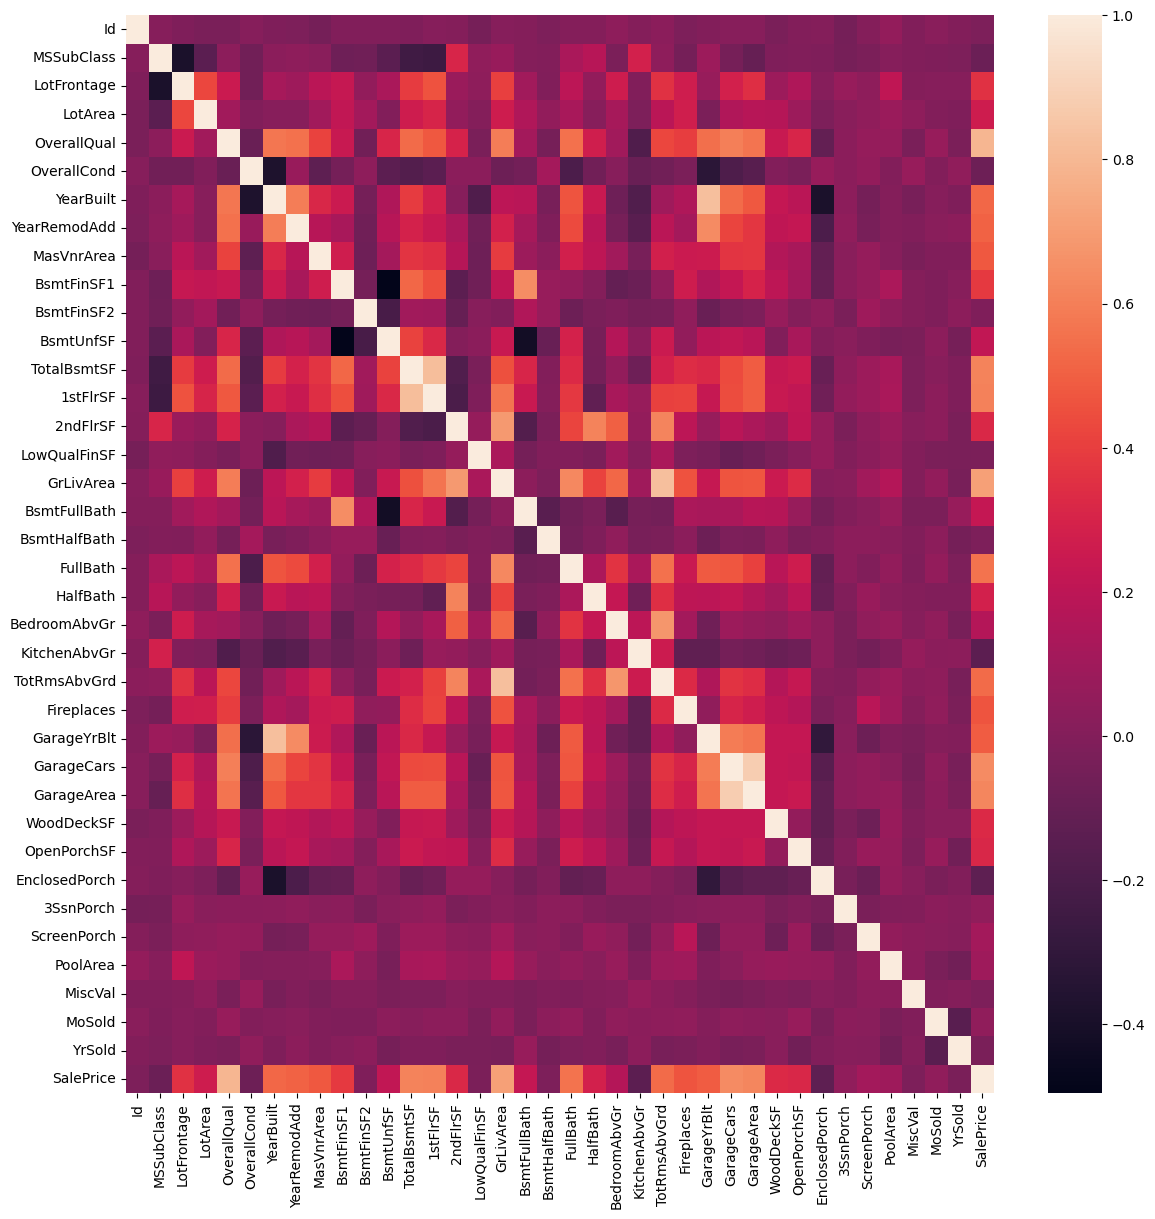

In [11]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(housing_num.select_dtypes(np.number).corr());

Some Features, specially the ones with highest correlations, are logically highly associated - it might be useful to drop those. Its hard to pin it down to a certain theshold, though. I will try with  r<0.6, within the curstom transformer

In [9]:
data1 = housing_num.copy()
data1

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [6]:
# Functions to integrate into the pipeline 

def find_features_to_keep(X, r = 0.6):
    # Create correlation matrix.
    corrMatrix = pd.DataFrame(X).corr().abs()

    # Select the upper triangle of the correlation matrix.
    upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))

    # Find the index of those feature columns with correlation smaller than r
    to_keep = [column for column in upper.columns if any(upper[column] <= r)]

    return to_keep

def do_nothing(X, r = 0.6):
    return X

### Log Transformation of skewed features and outcome

1.880940746034036


c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


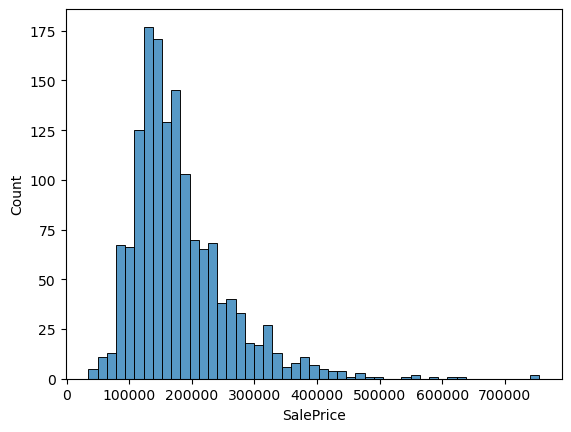

In [10]:
#SimpleImputer().fit_transform(data).set_output()
sns.histplot(data1["SalePrice"])
print(skew(data1["SalePrice"]))

0.12122191311528363


c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


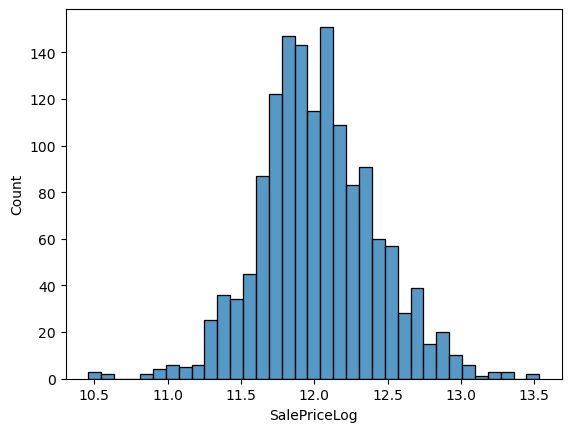

In [11]:
# log-transform the outcome
data1["SalePriceLog"] = np.log1p(data1.SalePrice)
sns.histplot(data1["SalePriceLog"])
print(skew(data1["SalePriceLog"]))

that looks much better.
the log must be reversed on the predicted y-labels in the end, using `np.expm1()`

Deal with skewed features from within the pipeline, using an adaptable skewness threshold

In [12]:
# Define a function to identify skewed features - to use within the pipeline
def identify_skewed_features(X, skew_threshold=0.5):
    skewness = pd.DataFrame(X).apply(lambda x: skew(x))
    skewed_features = skewness[skewness > skew_threshold].index
    return skewed_features

# Define a function to apply log transformation to skewed features
def log_transform(X):
    return np.log1p(X)

## Pipeline & Models

In [13]:
# log-transform y_train
y_train = np.log1p(y_train)

In [14]:
# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"),
    ColumnTransformer(transformers=[('nothing', FunctionTransformer(do_nothing), find_features_to_keep)], remainder='drop'),                    # drop collinear features
    ColumnTransformer(transformers=[('log_transform', FunctionTransformer(log_transform), identify_skewed_features)], remainder='passthrough')  # log-transform skewed features
)

 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_hot_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist',min_frequency=0.03)
)

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_ord_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OrdinalEncoder(categories=[globals()[f"{_}_cat"] for _ in X_ord_columns])  # access each cat_name variable by the X_ord_columns-list 
)

# Build preprocessor
preprocessor = make_column_transformer(
    (numeric_pipe, X_num_columns),
    (categoric_hot_pipe, X_cat_columns),
    (categoric_ord_pipe, X_ord_columns),
)

# Create Full Pipeline with ML model 
full_pipeline = make_pipeline(  preprocessor,
                                SelectKBest(score_func=f_regression),           # select k best features
                                VarianceThreshold(threshold=0),                 # exclude no-variance features
                                StandardScaler(),
                                GradientBoostingRegressor()
                                # DecisionTreeRegressor()
                                # SGDRegressor()
                                # LinearRegression()
                                # RFECV(RandomForestRegressor(), n_jobs=-2, cv=None)
                                # RandomForestRegressor()
                                )

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('columntransformer-1',
                                                                   ColumnTransformer(transformers=[('nothing',
                                                                                                    FunctionTransformer(func=<function do_nothing at 0x0000025C4055CB80>),
                                                                                                    <function find_features_to_keep at 0x0000025C4055CD60>)])),
                                                                  ('columntransformer-2',
                                                                   Colum...
                                                   'LotShape', 'Utilities',
                                                   'LandSlope', 'BsmtFinType2',
                                                   'HeatingQC', 'Functional',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000025C3DAAD260>)),
                ('variancethreshold', VarianceThreshold(threshold=0)),
                ('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [15]:
# define parameter grid
param_grid = {
    'standardscaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    
    "columntransformer__pipeline-1__simpleimputer__strategy":["mean", "median"],                  
    "columntransformer__pipeline-2__onehotencoder__min_frequency": np.arange(0.01, 0.11, 0.02),
    "columntransformer__pipeline-1__columntransformer-1__nothing__kw_args": [{'r': r} for r in np.arange(0.1, 1.1, 0.2)],
    
    #"decisiontreeregressor__max_depth" : range(6,18,4)

    # 'randomforestregressor__n_estimators': [100, 200, 300],  # Number of trees in the forest
    # 'randomforestregressor__max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
    # 'randomforestregressor__min_samples_split': [2, 5, 10],  # Minimum number of data points placed in a node before the node is split
    # 'randomforestregressor__min_samples_leaf': [1, 2, 4],  # Minimum number of data points allowed in a leaf node
    # 'randomforestregressor__max_features': [1, 'sqrt', 'log2'],  # Number of features to consider at every split

    # 'rfecv__estimator__n_estimators': [100, 200, 300],  # Number of trees in the forest
    # 'rfecv__estimator__max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
    # 'rfecv__estimator__min_samples_split': [2, 5, 10],  # Minimum number of data points placed in a node before the node is split
    # 'rfecv__estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of data points allowed in a leaf node

    "selectkbest__k" : [10,15,20,25,30],

}

# define cross validation. RandomizedSearchCV is much faster. n_iter is additional to GridSearchCV and defines the nr of iterations (default=10) 
search = RandomizedSearchCV( full_pipeline,
                                    param_grid,
                                    cv=5,                                       # the value for K in K-fold Cross Validation
                                    refit=True,                                 # Refit an estimator using the best found parameters on the whole dataset, (default = True)
                                    scoring='neg_root_mean_squared_log_error',  # the kaggle competition is rated based on this performance metric 
                                    verbose=5,                                  # we want informative outputs during the training process 
                                    n_iter=500,                                 # nr of iterations, must be balanced between model complexity and computational power/time
                                    n_jobs=-2                                   # the number of processors we want to employ. 
                                    )

In [ ]:
# find out attribute syntax for superparameter options
full_pipeline.named_steps["columntransformer"].named_transformers_["pipeline-1"].named_steps.columntransformer.named_transformers_["nothing"] #.named_steps#["transformers"]
full_pipeline.named_steps["columntransformer"].named_transformers_["pipeline-1"].named_steps.columntransformer.get_params()

In [16]:
search.fit(X_train, y_train)    

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('columntransformer-1',
                                                                                                ColumnTransformer(transformers=[('nothing',
                                                                                                                                 FunctionTransformer(func=<function do_nothing at 0x0000025C4055CB80>),
                                                                                                                                 <function find_features_to_keep at 0x0000025C4055CD60...
                                                                                                                 {'r': 0.9000000000000001}],
                                        'columntransformer__pipeline-1__simpleimputer__strategy': ['mean',
                                                                                                   'median'],
                                        'columntransformer__pipeline-2__onehotencoder__min_frequency': array([0.01, 0.03, 0.05, 0.07, 0.09]),
                                        'selectkbest__k': [10, 15, 20, 25, 30],
                                        'standardscaler': [StandardScaler(),
                                                           MinMaxScaler(),
                                                           RobustScaler()]},
                   scoring='neg_root_mean_squared_log_error', verbose=5)

In [243]:
search.best_params_

{'standardscaler': StandardScaler(),
 'columntransformer__pipeline-2__onehotencoder__min_frequency': 0.01,
 'columntransformer__pipeline-1__simpleimputer__strategy': 'median'}

### Model Summary

In [244]:
# whats the predictons quality?
y_pred_test = search.predict(X_test)

# reverse-log-transform y_test
y_pred_test = np.expm1(y_pred_test)

# Display (and add) model performance parameters to csv list
regression_perf(y_test, y_pred_test, "GradBooReg_log", save=False)

model      MAE          MSQ   MAPE     R2  \
0                             dummy  32465.8      47260.6  0.192  0.653   
1                        DecTreeReg  26479.6      45431.9  0.153  0.679   
2                            SDGReg  21669.2      36018.6  0.131  0.798   
3                            LinReg  20752.8      36313.3  0.123  0.795   
4                      RandomForest  15933.6      30369.0  0.091  0.857   
5       RandomForest_col+log+no0var  15855.3      30125.6  0.093  0.859   
6   RandomForest_col+log+no0var+RFE  15732.8      30849.1  0.091  0.852   
7   RandomForest_col+log+no0var+RFE  15946.4      31727.6  0.092  0.843   
8                        GradBooReg  14586.1  802954890.1  0.083  0.875   
9                    GradBooReg_log  14461.5  730567267.4  0.083  0.886   
10  new (not saved): GradBooReg_log  15205.0  862044715.6  0.085  0.866   

       RMSE  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5   30125.6  
6   30849.1  
7   31727.6  
8   28336.5  
9   27029.0  
10  29360.6

<Axes: ylabel='model'>

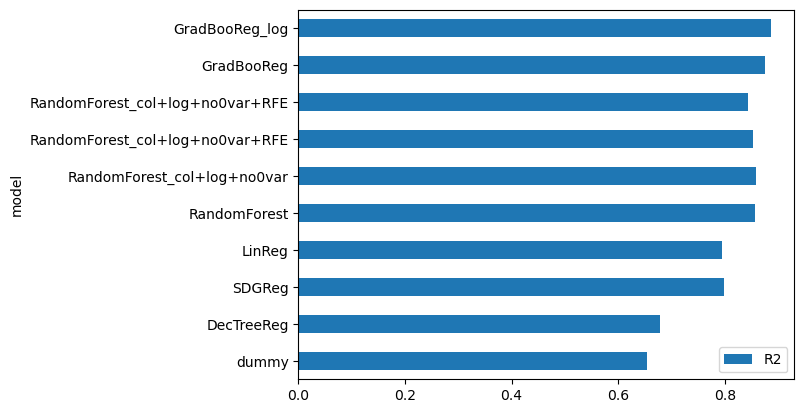

In [114]:
perf_reg_models = pd.read_csv("data/model_performance_regression.csv")

perf_reg_models.plot.barh(x="model", y="R2")

The initial performance is surprisingly low with R2 <0.8.

After trying many different ML methods, feature selection/engineering tools and superparameters tunings, I can summarize:
- tuning superparameters of ML modesl did not help in most cases
- changing the right ML model has the highest influence. RandomTreeRegresssor was strong, and GradientBoostingRegressor even stronger
- FeatureSelection and - Engineering like, exluding colinear features, log-transforming skewed features, exlcuding features with null-variance and so on, overall did not positivly influence the outcome
- log-transforming the outcome parameter did not improve the model

### Further explore the residuals

c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


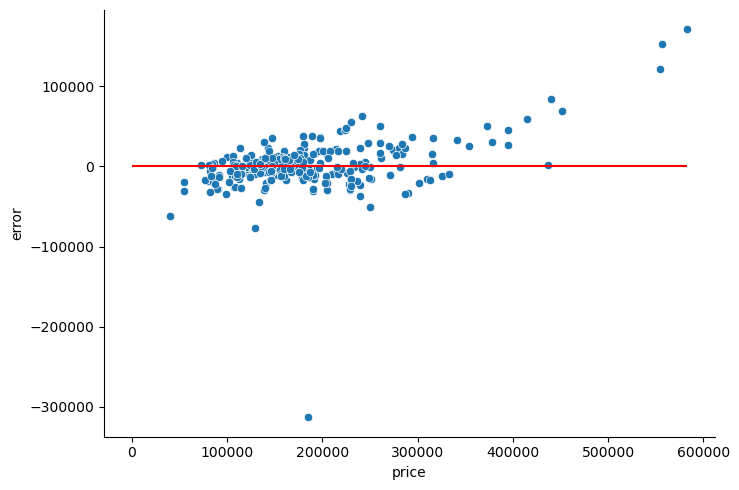

In [228]:
resid = pd.DataFrame({"price" : y_test, "price_pred" : y_pred_test.round(1)})
resid["error"] = resid["price"] - resid["price_pred"]

sns.displot(resid['error'],aspect=1.5)
plt.vlines(x=0,
           ymin=0,
           ymax=50,
           color='red')


sns.relplot(data=resid,
            x='price',
            y='error',
            aspect=1.5
            )
plt.hlines(y=0,
           xmin=0,
           xmax=max(resid['price']),
           color='red')

All three models residuals show a good (almost normal) distribution with persistant outliers. High priced houses are underpredicted

## Competetion data
Now that we have trained the model on the training data, we can test it on kaggles test data and upload the predictions to compete with data science enthusiasts from around the globe.

In [117]:
housing_kaggle = pd.read_csv("data/housing_complete/test.csv")
housing_kaggle

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]

In [118]:
housing_kaggle.shape

(1459, 80)

In [119]:
# Pop id
housing_kaggle_id = housing_kaggle.pop("Id")

In [ ]:
y_pred_kaggle = search.predict(housing_kaggle)

# reverse-log-transform y_test
y_pred_tey_pred_kagglest = np.expm1(y_pred_kaggle)

In [126]:
# create df, save to csv and upload
housing_kaggle_result = pd.DataFrame({"Id" : housing_kaggle_id, "SalePrice" : y_pred_kaggle})
housing_kaggle_result.to_csv("data/housing_kaggle_result_2.csv", index=False)